## Let's create a graph

In [1]:
from raphtory import graph_loader
from raphtory import Graph
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
g = Graph()
g

Graph(number_of_edges=0, number_of_vertices=0, earliest_time=0, latest_time=0)

In [3]:
from raphtory import Graph
g = Graph()
g.add_edge("2021-01-01 12:32:00", "Ben", "Hamza", {"type": "friend"})
g.add_edge("2021-01-02 14:15:36", "Hamza", "Haaroon", {"type": "friend"})
print("Total vertices in the graph:", g.num_vertices())
print("Total vertices at 2021-01-01 12:40:00:", g.at("2021-01-01 12:40:00").num_vertices())


Total vertices in the graph: 3
Total vertices at 2021-01-01 12:40:00: 2
1


## Adding some vertex history

In [4]:

g.add_vertex(timestamp=1, id="ben", properties={"property 1": 1, "property 3": "hi", "property 4": True})
g.add_vertex(timestamp=2, id="ben", properties={"property 1": 2, "property 2": 0.6, "property 4": False})
g.add_vertex(timestamp=3, id="ben", properties={"property 2": 0.9, "property 3": "hello", "property 4": True})

g.add_vertex_properties(id="ben", properties={"static property": 123})

g.vertex("ben").property_history("property 1")

[(1, 1), (2, 2)]

## Adding some edge history

In [5]:

g.add_vertex(timestamp=1,id="hamza")
g.add_edge(timestamp=1, src="ben", dst="hamza", properties={"property 1": 1, "property 3": "hi", "property 4": True})
g.add_edge(timestamp=2, src="ben", dst="hamza", properties={"property 1": 2, "property 2": 0.6, "property 4": False})
g.add_edge(timestamp=3, src="ben", dst="hamza", properties={"property 2": 0.9, "property 3": "hello", "property 4": True})

g.add_edge_properties(src="ben", dst="hamza", properties={"static property": 123})

g.edge("ben","hamza")

Edge(source=ben, target=hamza, earliest_time=1, latest_time=3, properties={property 2 : 0.9, static property : 123, property 1 : 2, property 3 : hello, property 4 : true})

## Loading a real graph

In [6]:
reddit_graph = graph_loader.reddit_hyperlink_graph()

In [7]:
print(reddit_graph)

Graph(number_of_edges=234792, number_of_vertices=54075, earliest_time=1388506820000, latest_time=1493570870000)


In [8]:
edge = reddit_graph.edge("conspiracy","documentaries")
print("property names:",edge.property_names())
print("sentiment history:",edge.property_history("compound_sentiment"))

date="2014-10-30 13:45:00"
edge_perspective = reddit_graph.at(date).edge("conspiracy","documentaries")
print("Most recent sentiment on",date,"-",edge_perspective["compound_sentiment"])

reddit_graph.vertex("conspiracy").out_neighbours().out_neighbours().out_neighbours()

property names: ['post_label', 'post_id', 'word_count', 'long_words', 'sentences', 'readability', 'positive_sentiment', 'negative_sentiment', 'compound_sentiment']
sentiment history: [(1404952792000, 0.2732), (1414676601000, 0.2344), (1418639874000, 0.0), (1420030124000, -0.2481), (1426362695000, 0.0), (1427198700000, -0.2023), (1427894452000, 0.0), (1429187302000, 0.5562), (1429644527000, 0.296), (1431911341000, -0.3595), (1433653011000, -0.34), (1435258425000, 0.0772), (1439068701000, -0.5574), (1439249314000, 0.0), (1440456620000, 0.4019), (1446586617000, 0.0), (1447125847000, -0.7042), (1447422296000, 0.0387), (1450563607000, 0.8192), (1450658697000, 0.6841), (1450863723000, 0.2732), (1451249771000, -0.4767), (1455119795000, 0.0), (1455295188000, -0.4939), (1456505801000, -0.6908), (1456949833000, 0.0), (1458061181000, 0.3384), (1460498612000, -0.5267), (1461879765000, -0.6136), (1463741129000, 0.0), (1466862772000, -0.1779), (1471350739000, -0.6808), (1479538764000, 0.0), (1480262

PathFromVertex(Vertex(name=cancer, properties={_id : cancer}), Vertex(name=soccer, properties={_id : soccer}), Vertex(name=pics, properties={_id : pics}), Vertex(name=funny, properties={_id : funny}), Vertex(name=bitcoin, properties={_id : bitcoin}), Vertex(name=propaganda, properties={_id : propaganda}), Vertex(name=conspiracy, properties={_id : conspiracy}), Vertex(name=askreddit, properties={_id : askreddit}), Vertex(name=trees, properties={_id : trees}), Vertex(name=cricket, properties={_id : cricket}), ...)

## Let's have a look at the daily traffic

<Axes: xlabel='Time', ylabel='Interactions'>

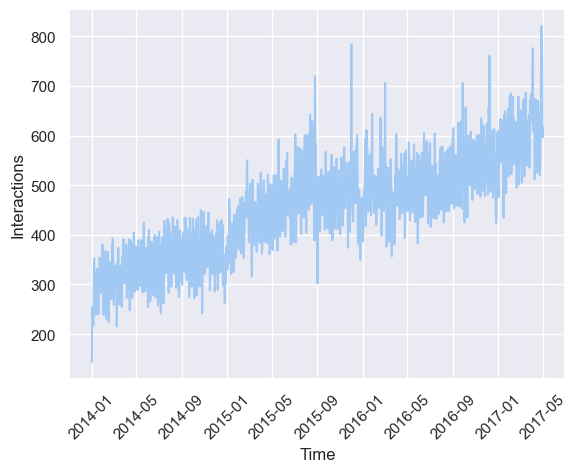

In [13]:
views = reddit_graph.rolling(window="1 day") 

timestamps   = []
edge_count   = []

for view in views:
    timestamps.append(view.latest_date_time())
    edge_count.append(view.num_edges())            

sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Interactions")
sns.lineplot(x = timestamps, y = edge_count,ax=ax)

## Average Weekly sentiment for a given subreddit

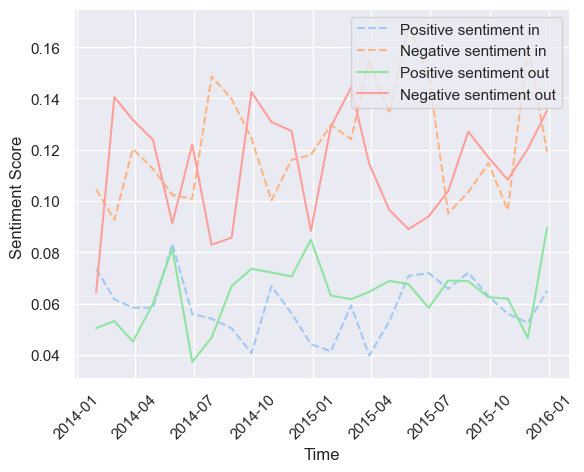

In [15]:
views = reddit_graph.window("2014-01-01 00:00:00","2016-01-01 00:00:00").vertex("conspiracy").rolling("1 month") 
timestamps             = []
positive_sentiment_in  = []
positive_sentiment_out = []
negative_sentiment_in  = []
negative_sentiment_out = []

def edge_weight(edge,prop_name):
    return sum(list(map(lambda e: e[1],edge.property_history(prop_name)))), len(edge.property_history(prop_name))

def weighted_average_degree(vertex,prop_name,incoming):
    edges = list(vertex.in_edges() if incoming else vertex.out_edges())
    return sum(list(map(lambda e: edge_weight(e,prop_name)[0],edges)))/max(1,sum(list(map(lambda e: edge_weight(e,prop_name)[1],edges))))

for vertex in views:
    timestamps.append(vertex.latest_date_time())
    positive_sentiment_in.append(weighted_average_degree(vertex,"positive_sentiment",incoming=True))
    positive_sentiment_out.append(weighted_average_degree(vertex,"positive_sentiment",incoming=False))
    negative_sentiment_in.append(weighted_average_degree(vertex,"negative_sentiment",incoming=True))
    negative_sentiment_out.append(weighted_average_degree(vertex,"negative_sentiment",incoming=False))        

sns.set()
sns.set_palette("pastel")
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Sentiment Score ")

sns.lineplot(x = timestamps, y = positive_sentiment_in,ax=ax,label="Positive sentiment in",linestyle="--")
sns.lineplot(x = timestamps, y = negative_sentiment_in,ax=ax,label ="Negative sentiment in",linestyle="--")
sns.lineplot(x = timestamps, y = positive_sentiment_out,ax=ax,label="Positive sentiment out")
sns.lineplot(x = timestamps, y = negative_sentiment_out,ax=ax,label ="Negative sentiment out")
ax.legend(loc="best")
